# The ARIMA model

## Library and data import

In [7]:
#Library imports
import re
import os
import time
import math
import random
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


#User Created functions
from eda_functions import *
from modeling_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
#Sets random seeds to allow for reproducable results.
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

Our main [dataset](https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory) was pulled from Kaggle. It contains data from a selection of various cyptocurrencies where price data was scraped from CoinMarketCap which in the timeline of the crptocurrency market had early on established itself as a popular player in providing market data from this new asset class

In [3]:
btc=pd.read_pickle("data/bitcoin.pickle")

## Data Preprocessing

This step includes removing columns we do not need, check missing values, transformations, differencing and so on


We decided to log the prices to remove the impact of significant outliers

In [5]:
btc_log = np.log(btc["Close"])

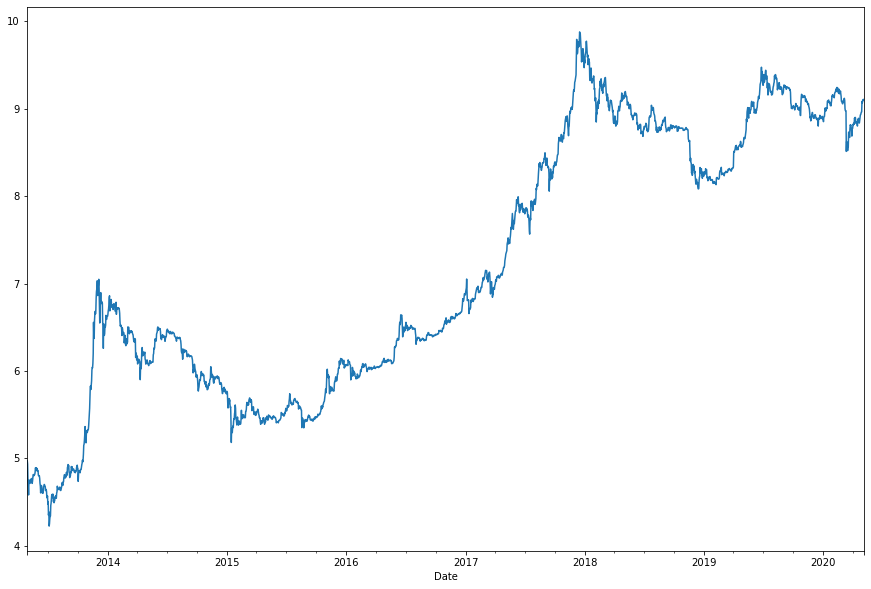

In [39]:
btc_log.plot(figsize=(15,10))

Logging alone will not bring the data to stationarity.

Some distinguishable patterns appear when we view the plotted data. The time-series has minimal seasonality pattern (as visible to our eyes). There have been a couple of distinct spikes and the overall trend seems to be positively sloped and is normalising We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

## Time Series Decomposition

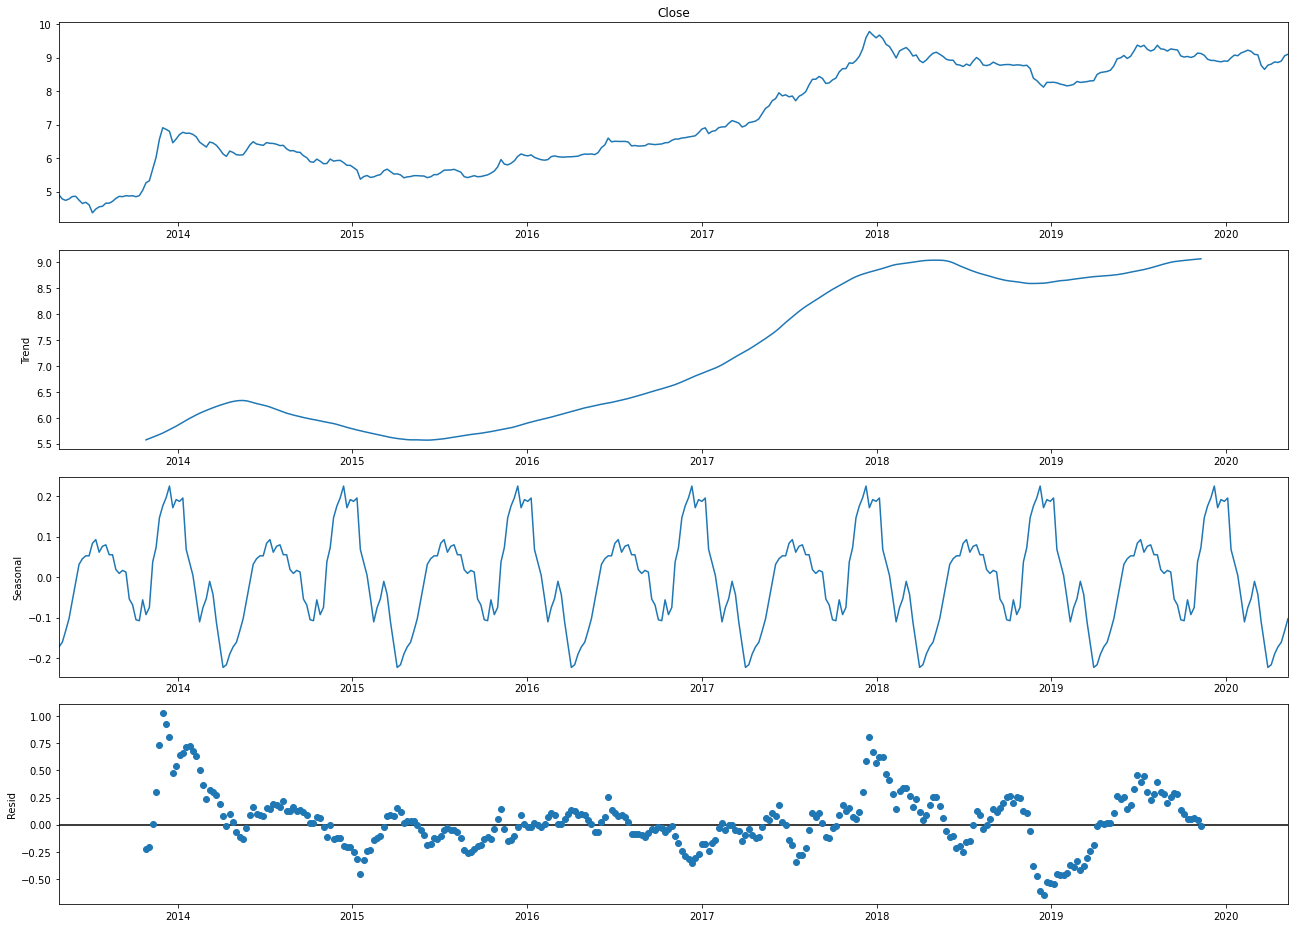

In [6]:
rcParams['figure.figsize'] = 18, 13
decomposition = sm.tsa.seasonal_decompose(btc_week_log, model='additive', period=52)
residual = decomposition.resid
fig = decomposition.plot()
plt.show()

Time series decomposition gives a more in-depth look into the underlying patterns in our data. Clearly the long term price of Bitcoin shows a upward linear trend. There seems to be a strong pattern in seasonality which we found interesting that may relate to investor investment cycles. Lastly the residuals appear normal except for phases in time when there is considerable deviation

Clearly we need to confirm and check that this series is not stationary before moving ahead.

## Asessing Trends in our data

We used two formal ways to assess trends:

#### Rolling statistics and The Dickey-Fuller Test

In rolling statistics, we can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean at any point in time 𝑡 , we can take the average/variance of the 𝑚 last time periods. 𝑚 is then known as the window size

The Dickey-Fuller test is a statistical test for testing stationarity. The null-hypothesis for the test is that the time series is not stationary. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary

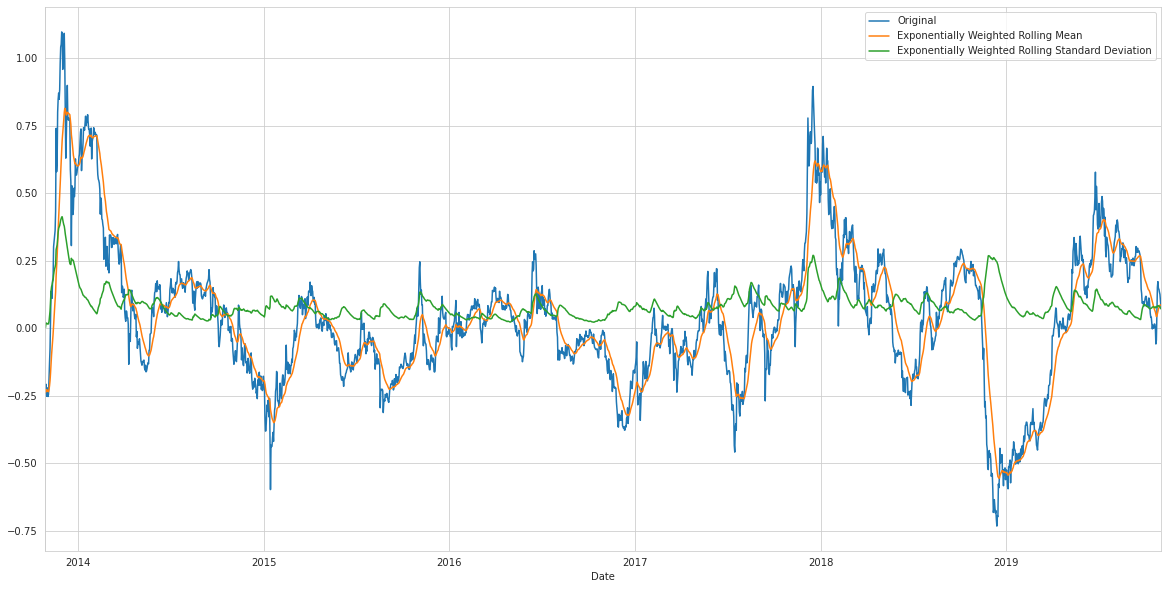

Test Statistic                   -3.919320
p-value                           0.001897
#Lags Used                       24.000000
Number of Observations Used    2173.000000
Critical Value (1%)              -3.433363
Critical Value (5%)              -2.862871
Critical Value (10%)             -2.567479
dtype: float64

In [46]:
stationarity_check(residual.dropna(), 8, figsize=(20, 10))

By breaking out the component factors, when inspecting the remaining residuals, we can safely reject the null hypothesis that this series is not stationary since p-value < threshold~5%

Given a statistical confirmation of our visual analysis, removing the factors could be a viable approach into achieving stationarity. We decided to explore the possibility of achieving stationarity through differencing our log transformed time series.

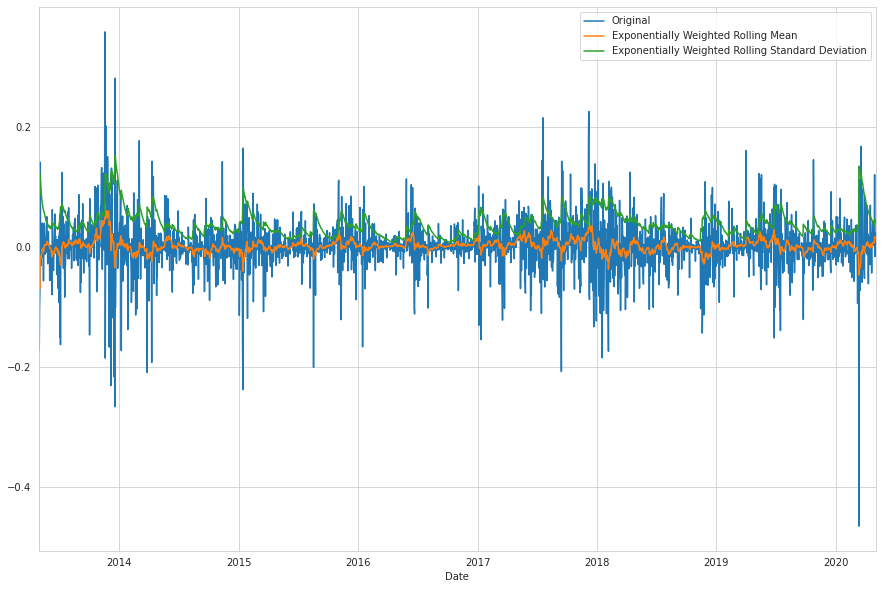

Test Statistic                -9.421022e+00
p-value                        5.502958e-16
#Lags Used                     2.200000e+01
Number of Observations Used    2.538000e+03
Critical Value (1%)           -3.432929e+00
Critical Value (5%)           -2.862679e+00
Critical Value (10%)          -2.567377e+00
dtype: float64

In [25]:
stationarity_check(btc_log.diff(1).dropna(), 8, figsize=(15, 10))

Since our test statistic is less than our desired threshold of 5%,we can reject the null hypothesis that this is not a stationary series and move on the next step of our process - identifying autocorrelation and partial autocorrelation in our data

## Autocorrelation (ACF) & Partial ACF (PACF)

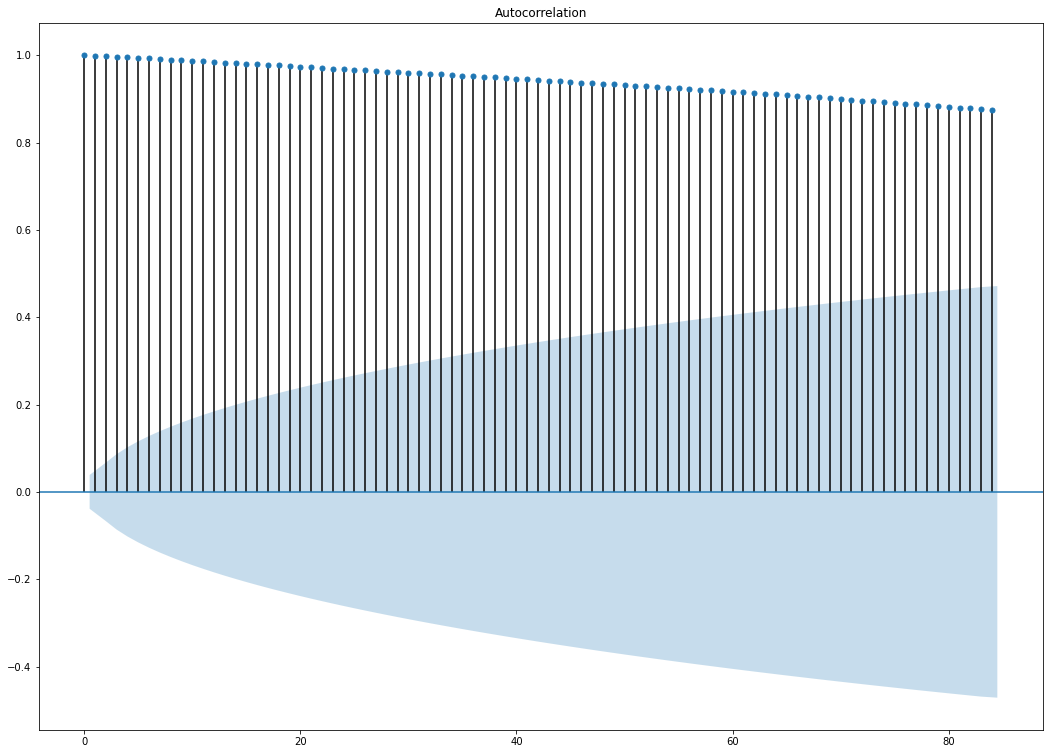

In [9]:
rcParams['figure.figsize'] = 18, 13
plot_acf(btc_log, alpha=.05, lags=7*12)
plt.show()

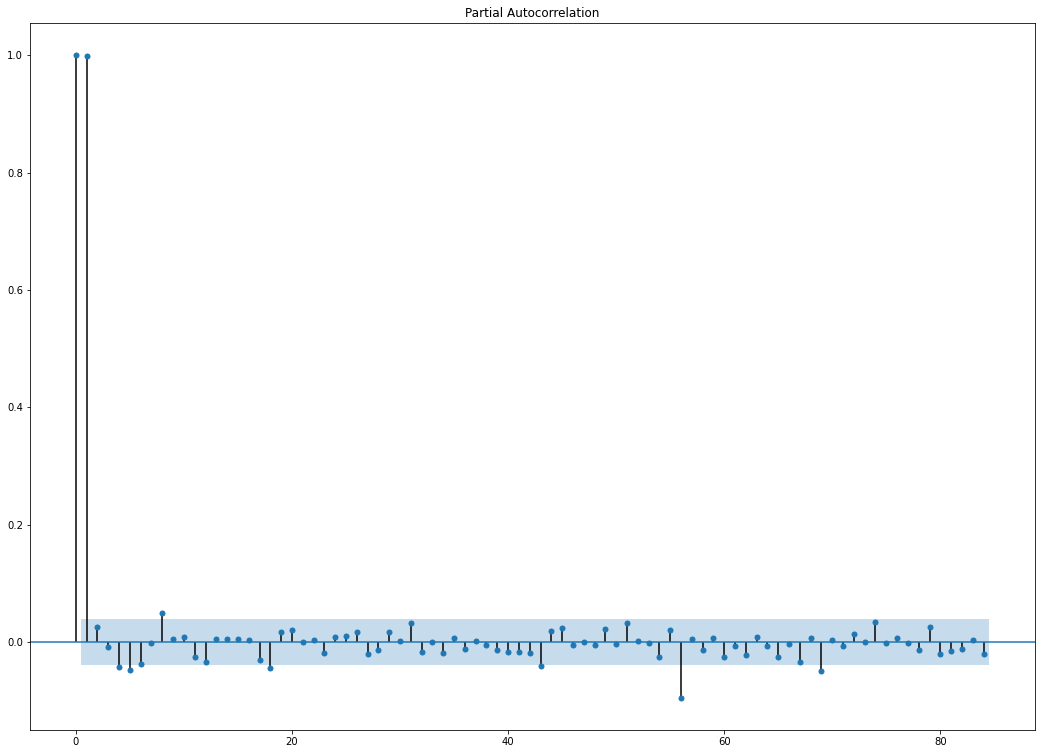

In [10]:
rcParams['figure.figsize'] = 18, 13
plot_pacf(btc_log, alpha=.05, lags=7*12)
plt.show()

Based on our analysis of the ACF & PACF, we are ready to start building a baseline model. But before we do that, we need to split our data into training and testing datasets for validation purposes

## Let's commence the train, test, and split

In [31]:
btc_log_train, btc_log_test = btc_log[:"2020-04-04"], btc_log["2020-04-05":]

In [32]:
btc_week_log_train, btc_week_log_test = btc_week_log[:"2020-04-04"], btc_week_log["2020-04-05":]

We split our data

To optimize our parameters, P,Q, and R, we performed a grid search. There was significant overhead in fitting with seasonality over a one year duration. We resampled our data to have less observations in order for the search to run faster.

In [ ]:
pdq_params = pdq_hyperparam_search(btc_week_log_train, 52, max_p=2, max_d=1, max_q=2)

The results of the entire search are saved to a DataFrame. We will examine the top performing hyperparmeters on the full data.

In [171]:
pdq_params

,PDQ,S-PDQ,Error
0,"(1, 0, 2)","(0, 0, 0, 52)",2.738853e-01
1,"(0, 1, 2)","(0, 0, 0, 52)",2.739559e-01
2,"(1, 0, 1)","(0, 0, 0, 52)",2.742747e-01
3,"(0, 1, 1)","(0, 0, 0, 52)",2.743796e-01
4,"(0, 1, 2)","(0, 0, 1, 52)",2.753638e-01
...,...,...,...
319,"(0, 0, 1)","(2, 0, 2, 52)",2.459950e+08
320,"(0, 0, 1)","(0, 0, 2, 52)",1.084632e+09
321,"(0, 0, 2)","(2, 0, 2, 52)",1.234379e+09
322,"(0, 0, 2)","(1, 0, 2, 52)",2.912789e+09


In [172]:
pdq_full_params = pdq_hyperparam_df_search(btc_log_train, pdq_params=pdq_params, new_period=365, n_combs=2)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA(1, 0, 2)x[0, 0, 0, 365]12 - rmse:0.10673741409187877
ARIMA(0, 1, 2)x[0, 0, 0, 365]12 - rmse:0.1067480421324613


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



## Fitting the model and making predictions

In [14]:
mod = sm.tsa.statespace.SARIMAX(btc_log_train,
                                order=(1, 0, 2),
                                seasonal_order=(0, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002      0.000   8628.039      0.000       1.000       1.000
ma.L1         -0.0142      0.011     -1.346      0.178      -0.035       0.006
ma.L2         -0.0013      0.014     -0.095      0.924      -0.028       0.025
sigma2         0.0019   2.05e-05     92.183      0.000       0.002       0.002


The p-values for both the MA terms were much higher than a significance level of .05, so we were forced to drop them from our model. The new one contains one lag of autoregression, which was highly visible in our acf and pacf plots.

In [42]:
mod = sm.tsa.statespace.SARIMAX(btc_log_train,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002      0.000   8514.590      0.000       1.000       1.000
sigma2         0.0019   2.05e-05     92.300      0.000       0.002       0.002


In [46]:
results.get_prediction(start=btc_log_test.index[0], end=btc_log_test.index[-1], dynamic=False).predicted_mean

2020-04-05    8.836170
2020-04-06    8.837780
2020-04-07    8.839391
2020-04-08    8.841001
2020-04-09    8.842613
2020-04-10    8.844224
2020-04-11    8.845836
2020-04-12    8.847448
2020-04-13    8.849060
2020-04-14    8.850673
2020-04-15    8.852286
2020-04-16    8.853899
2020-04-17    8.855512
2020-04-18    8.857126
2020-04-19    8.858740
2020-04-20    8.860355
2020-04-21    8.861969
2020-04-22    8.863584
2020-04-23    8.865200
2020-04-24    8.866815
2020-04-25    8.868431
2020-04-26    8.870047
2020-04-27    8.871664
2020-04-28    8.873280
2020-04-29    8.874897
2020-04-30    8.876515
2020-05-01    8.878132
2020-05-02    8.879750
2020-05-03    8.881369
2020-05-04    8.882987
2020-05-05    8.884606
Freq: D, dtype: float64

We plot the results.

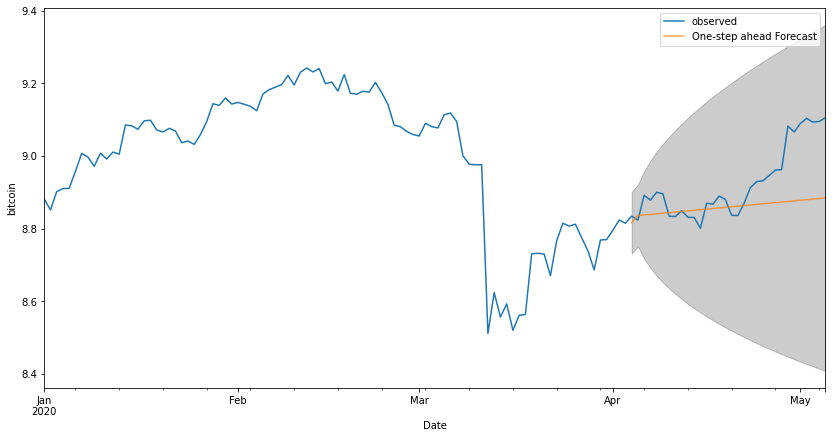

In [44]:
pred = results.get_prediction(start=pd.to_datetime('2020-04-04'), end=pd.to_datetime('2020-05-05'), dynamic=False)
pred_ci = pred.conf_int()
ax = btc_log["2020":].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('bitcoin')
plt.legend()
plt.show()

In [47]:
y_forecasted = np.exp(pred.predicted_mean)
y_truth = np.exp(btc_log_test)
mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {round(mse, 2)}, Root Mean Squared Error: {round(rmse, 2)}')

Mean Squared Error: 732107.26, Root Mean Squared Error: 855.63


The results indicate that the prediction was not sufficient in predicting the price spike that happened at the start of May.